Binary Segmentation using UNet with EfficientNet B0 as encoder.

TF Version:  2.13.0
Model: "EfficientNetB1_UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 256, 256, 3)          0         ['input_6[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_8[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_9 (Rescaling)     (None, 256, 256, 3)          0 

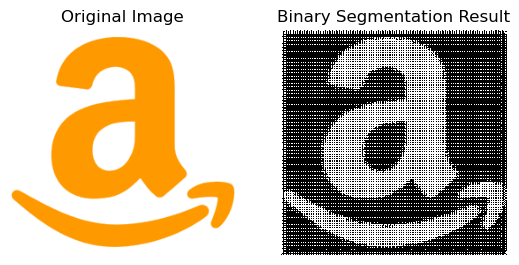

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

print("TF Version: ", tf.__version__)

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_efficientnet_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Encoder """
    encoder = EfficientNetB1(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = encoder.layers[0].output
    s2 = encoder.get_layer("block2a_expand_activation").output
    s3 = encoder.get_layer("block3a_expand_activation").output
    s4 = encoder.get_layer("block4a_expand_activation").output

    """ Bottleneck """
    b1 = encoder.get_layer("block6a_expand_activation").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="EfficientNetB1_UNET")
    return model

def calculate_threshold(segmentation_result):
    # Calculate threshold dynamically
    min_val = tf.reduce_min(segmentation_result)
    max_val = tf.reduce_max(segmentation_result)
    threshold = (min_val + max_val) / 2.0
    return threshold

def display_segmentation_result(model, img_array):
    # Predict segmentation result
    segmentation_result = model.predict(img_array)

    # Calculate threshold dynamically
    threshold = calculate_threshold(segmentation_result)

    # Thresholding - convert to binary
    binary_segmentation = tf.cast(segmentation_result > threshold, tf.uint8)

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_array[0])
    plt.axis('off')
    plt.title('Original Image')

    # Display the binary segmentation result
    plt.subplot(1, 2, 2)
    plt.imshow(binary_segmentation[0, :, :, 0], cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.title('Binary Segmentation Result')

    plt.show()

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_efficientnet_unet(input_shape)
    model.summary()

    # Load a sample image (replace with your image loading logic)
    img_path = 'C:/Users/Divyadarshini/Downloads/pngimg.com - amazon_PNG18.png'
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to between 0 and 1

    # Display the segmentation result
    display_segmentation_result(model, img_array)
